In [1]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

In [2]:
import numpy as np, pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Chargement du corpus

In [3]:
DATA_PATH = "../data/raw/spam.csv"

df_base = pd.read_csv(DATA_PATH, encoding="latin-1")
df_base.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df_base.drop(columns=df_base.columns[df_base.columns.str.contains('^Unnamed')], inplace=True)
df_base.columns = df_base.columns.str.strip()
df_base = df_base.rename(columns={'v1': 'label', 'v2': 'text'})

In [5]:
df_base.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df_spam = df_base.query("label == 'spam'").copy()
df_ham  = df_base.query("label == 'ham'").copy()

In [7]:
df_ham.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...


In [8]:
df_spam.head()

,label,text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


# Fréquence des mots rares vs. communs

In [9]:
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])

In [10]:
all_tokens = []
for doc in nlp.pipe(df_base["text"], disable=["ner", "parser", "tagger"]):
    all_tokens += [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]

freq = Counter(all_tokens)

# Définition des mots rares
RARE_THRESHOLD = 3
rare_words = {w for w, c in freq.items() if c < RARE_THRESHOLD}

# Calcul des mots rares par label
results = []
for label, subset in df_base.groupby("label"):
    label_tokens = []
    for doc in nlp.pipe(subset["text"], disable=["ner", "parser", "tagger"]):
        label_tokens += [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]

    total = len(label_tokens)
    rare = sum(1 for t in label_tokens if t in rare_words)

    results.append({
        "label": label,
        "total_tokens": total,
        "rare_tokens": rare,
        "percent_rare": (rare / total * 100) if total else 0
    })

pd.DataFrame(results)

c:\Users\jean-\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
c:\Users\jean-\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,label,total_tokens,rare_tokens,percent_rare
0,ham,32390,4986,15.393640
1,spam,8782,837,9.530859


In [11]:
# Bar chart : une visualisation par label
def doc_lemmas(texts):
    for doc in nlp.pipe(texts, disable=["ner", "parser", "tagger"]):
        yield [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]

lemmas_by_label = {}
for label, subset in df_base.groupby("label"):
    toks = sum(doc_lemmas(subset["text"]), [])
    lemmas_by_label[label] = toks

# 2) 
TOP_N = 25
for label, lemmas in lemmas_by_label.items():
    freq = Counter([w for w in lemmas if len(w) >= 3]).most_common(TOP_N)
    if not freq:
        continue

    df_top = pd.DataFrame(freq, columns=["Lemmes", "Fréquence"])
    df_top = df_top.sort_values("Fréquence", ascending=True)

    fig = px.bar(
        df_top,
        x="Fréquence",
        y="Lemmes",
        orientation="h",
        color="Fréquence",
        color_continuous_scale="viridis",
        title=f"Top {TOP_N} lemmes les plus fréquents - {label}",
    )
    fig.update_layout(
        yaxis=dict(categoryorder="total ascending"),
        xaxis_title="Fréquence",
        yaxis_title="Lemmes",
    )
    fig.show()

c:\Users\jean-\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


# Répartition des longueurs de mots
- Présence de mots très courts / très longs dans les spams

In [12]:
# Extraction des longueurs de lemmes
def word_lengths(texts):
    for doc in nlp.pipe(texts, disable=["ner", "parser", "tagger"]):
        yield [len(t.lemma_) for t in doc if t.is_alpha and not t.is_stop]

lengths_by_label = defaultdict(list)
for label, subset in df_base.groupby("label"):
    for lens in word_lengths(subset["text"]):
        lengths_by_label[label].extend(lens)

c:\Users\jean-\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning:

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.



In [13]:
# DataFrame une ligne = un mot
df_len = pd.DataFrame(
    [(lab, L) for lab, Ls in lengths_by_label.items() for L in Ls],
    columns=["label", "length"]
)

In [14]:
# Indicateurs simple
SHORT_THR = 3
LONG_THR  = 10

summary = (
    df_len
    .assign(short=lambda d: d["length"] <= SHORT_THR,
            long =lambda d: d["length"] >= LONG_THR)
    .groupby("label")
    .agg(
        mean_len = ("length","mean"),
        median_len=("length","median"),
        pct_short=("short", lambda s: 100*s.mean()),
        pct_long =("long",  lambda s: 100*s.mean()),
        n_words  =("length","size")
    )
    .round(2)
    .reset_index()
)
summary

,label,mean_len,median_len,pct_short,pct_long,n_words
0,ham,4.62,4.0,29.51,2.33,32390
1,spam,5.13,5.0,21.25,3.68,8782


In [15]:
#  Histogramme comparatif
fig_hist = px.histogram(
    df_len, x="length", color="label",
    nbins=20, barmode="overlay", histnorm="percent",
    title="Répartition des longueurs de mots (%) — spam vs ham"
)
fig_hist.update_layout(xaxis_title="Longueur du lemme (nb de caractères)", yaxis_title="% des mots")
fig_hist.show()

# Clustering thématique

In [16]:
def spacy_tok(s):
    doc = nlp(s)
    return [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop and len(t) > 2]

# --- 2) TF-IDF (unigrammes + bigrammes)
vec = TfidfVectorizer(tokenizer=spacy_tok, lowercase=False, ngram_range=(1,2), min_df=2, max_df=0.9)
X = vec.fit_transform(df_base["text"])
terms = np.array(vec.get_feature_names_out())

# --- 3) Choix rapide du nombre de clusters (silhouette)
def best_k(X, ks=(4,5,6,7,8)):
    best_s, best_k = -1, None
    for k in ks:
        km = KMeans(n_clusters=k, n_init="auto", random_state=0).fit(X)
        s = silhouette_score(X, km.labels_, sample_size=min(5000, X.shape[0]))
        if s > best_s:
            best_s, best_k = s, k
    return best_k

K = best_k(X)
print("K choisi:", K)

# KMeans
kmeans = KMeans(n_clusters=K, n_init="auto", random_state=0)
labels = kmeans.fit_predict(X)

# Top termes par cluster
def top_terms_per_cluster(X, labels, terms, topn=10):
    # centre de cluster = moyenne TF-IDF des points du cluster
    centers = []
    for c in range(labels.max()+1):
        centers.append(np.asarray(X[labels==c].mean(axis=0)).ravel())
    centers = np.vstack(centers)
    tops = {}
    for c in range(centers.shape[0]):
        idx = np.argsort(centers[c])[-topn:]
        tops[c] = list(reversed(terms[idx]))
    return tops

top_terms = top_terms_per_cluster(X, labels, terms, topn=10)
top_terms_df = pd.DataFrame([(c, ", ".join(ws)) for c, ws in top_terms.items()],
             columns=["cluster","top_terms"])

c:\Users\jean-\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



K choisi: 8


In [17]:
top_terms_df

,cluster,top_terms
0,0,"free, text, phone, stop, reply, mobile, send, ..."
1,1,"know, time, let, let know, want, like, need, n..."
2,2,"get, job, wat, yeah, get job, time, work, yeah..."
3,3,"love, miss, babe, day, good, hope, kiss, amp, ..."
4,4,"sorry later, sorry, later, later meeting, meet..."
5,5,"plan, today plan, plan come, what, what today,..."
6,6,"go, like, good, lor, send, think, day, want, t..."
7,7,"come, come home, home, time, tomorrow, come to..."


In [18]:
top_terms_df.to_csv("../data/outputs/spam_clusters.csv")

In [19]:
svd = TruncatedSVD(n_components=6, random_state=0)
XY = svd.fit_transform(X)

plot_df = pd.DataFrame({"x": XY[:,0], "y": XY[:,1], "cluster": labels.astype(str)})
fig = px.scatter(
    plot_df, x="x", y="y", color="cluster",
    title="Clustering thématique (TF-IDF + KMeans, SVD 2D)",
    hover_data={"cluster": True}
)
fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.show()

In [20]:
df_clusters = df_base.copy()
df_clusters["cluster"] = labels
ct = (df_clusters.groupby(["cluster","label"]).size()
      .unstack(fill_value=0))
ct

label,ham,spam
cluster,,
0,113,295
1,336,24
2,236,7
3,175,6
4,41,0
5,53,0
6,3645,412
7,226,3


# Sentiment analysis

In [25]:
# nltk
try:
    sia = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download("vader_lexicon")
    sia = SentimentIntensityAnalyzer()

# Score "compound" ∈ [-1,1] pour chaque message
df_sent = df_base.copy()
df_sent["compound"] = df_sent["text"].astype(str).map(lambda s: sia.polarity_scores(s)["compound"])

# Classe rapide : neg / neu / pos
def to_label(c):
    return "pos" if c >= 0.05 else ("neg" if c <= -0.05 else "neu")

df_sent["sentiment"] = df_sent["compound"].map(to_label)

# Répartition en % par catégorie (spam/ham)
dist = (
    df_sent.groupby(["label", "sentiment"], as_index=False)
           .size()
           .rename(columns={"size": "count"})
)
dist["percent"] = dist.groupby("label")["count"].transform(lambda s: 100*s/s.sum())

fig1 = px.bar(
    dist, x="label", y="percent", color="sentiment", barmode="stack",
    title="Répartition du sentiment (%) — spam vs ham",
    labels={"percent": "%", "label": "Label", "sentiment": "Sentiment"}
)
fig1.show()

# Synthèse
summary = (
    df_sent.groupby("label", as_index=False)["compound"]
           .agg(mean="mean", median="median",
                p10=lambda x: x.quantile(0.10),
                p90=lambda x: x.quantile(0.90))
           .round(3)
)
summary

,label,mean,median,p10,p90
0,ham,0.152,0.000,-0.339,0.731
1,spam,0.436,0.611,-0.297,0.906


# Wordclouds

In [22]:
extra_stop = {"amp","lt","gt","br","ul","li","http","https"}

def lemmas(texts):
    for doc in nlp.pipe(texts, disable=["ner","parser","tagger"]):
        yield [t.lemma_.lower() for t in doc
               if t.is_alpha and not t.is_stop and len(t)>2 and t.lemma_.lower() not in extra_stop]

# fréquences par label (dict: label -> Counter)
def lemma_freq_by_label(df):
    out = {}
    for lab, sub in df.groupby("label"):
        out[lab] = Counter()
        for toks in lemmas(sub["text"].astype(str)):
            out[lab].update(toks)
    return out

freqs = lemma_freq_by_label(df_base)

c:\Users\jean-\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning:

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.

c:\Users\jean-\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning:

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.



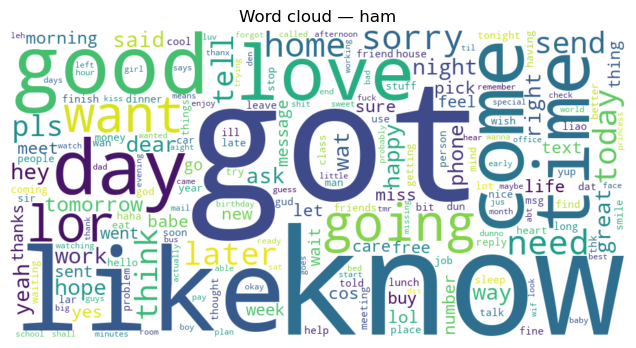

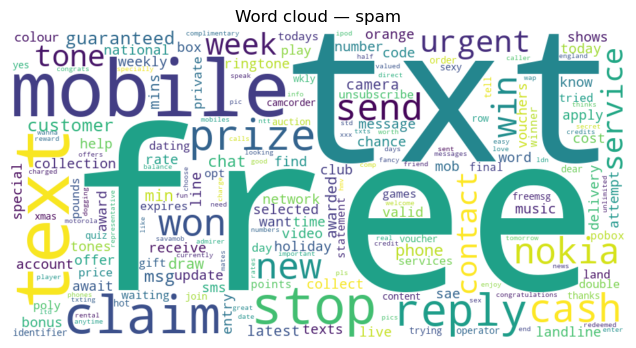

In [23]:
# Nuages de mots comparatifs
for lab in ["ham","spam"]:
    if lab not in freqs: 
        continue
    wc = WordCloud(width=900, height=450, background_color="white")
    img = wc.generate_from_frequencies(freqs[lab])
    plt.figure(figsize=(9,4))
    plt.imshow(img, interpolation="bilinear"); plt.axis("off")
    plt.title(f"Word cloud — {lab}")
    plt.show()

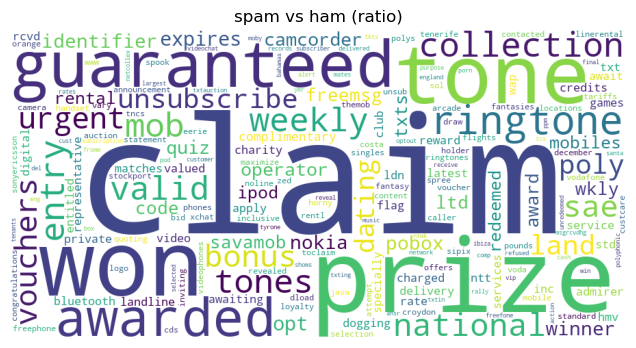

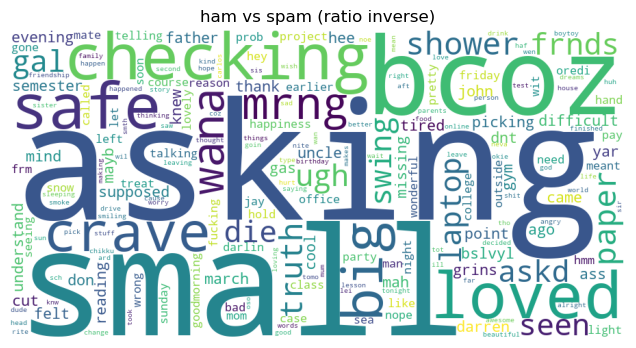

In [24]:
# Cloud comparatif : termes discriminants
all_terms = set(freqs.get("spam",{})) | set(freqs.get("ham",{}))
rows=[]
for w in all_terms:
    s, h = freqs.get("spam",{}).get(w,0)+1, freqs.get("ham",{}).get(w,0)+1
    rows.append((w, s/h))
rank = pd.DataFrame(rows, columns=["term","spam_ham_ratio"]).sort_values("spam_ham_ratio", ascending=False)
top_spam = dict(rank.head(300).set_index("term")["spam_ham_ratio"])
top_ham  = dict(rank.tail(300).set_index("term")["spam_ham_ratio"])

# clouds pondérés par le ratio
for title, dct in [("spam vs ham (ratio)", top_spam), ("ham vs spam (ratio inverse)", top_ham)]:
    wc = WordCloud(width=900, height=450, background_color="white").generate_from_frequencies(dct)
    plt.figure(figsize=(9,4)); plt.imshow(wc); plt.axis("off"); plt.title(title); plt.show()